In [ ]:
import matplotlib.pyplot as plt


from utils import *
from ardca import *
from classes import *

In [ ]:
msa_path = "../data/PF00014_mgap6.fasta.gz"
alignment = read_fasta_alignment(msa_path, max_gap_fraction=1.0)

In [ ]:
params = ModelParams(
    lambda_h=1e-6,
    lambda_J=1e-4,
    optimizer="LBFGS",
    max_iters=1000,
    seed=0,
    val_frac=0.2
)

theta=0.8
device="cpu"
    

print("Computing weights on full MSA")
W, M_eff = compute_weights(alignment, theta, gap_idx=0, count_gaps_as_match=False)

Xtr, Wtr, Xval, Wval = split_sequences(alignment, W, val_frac=params.val_frac, seed=params.seed)
seqs_tr  = torch.from_numpy(Xtr.astype(np.int64)).to(device)
w_tr     = torch.from_numpy(Wtr.astype(np.float32)).to(device)
seqs_val = torch.from_numpy(Xval.astype(np.int64)).to(device)
w_val    = torch.from_numpy(Wval.astype(np.float32)).to(device)

print(f"Train: {Xtr.shape[0]}  Val: {Xval.shape[0]}  L={alignment.shape[1]}")
print("Training on train split")
model, metrics = train_ardca_torch(seqs_tr, w_tr, q=21,
                                       lambda_h=params.lambda_h, lambda_J=params.lambda_J,
                                       optimizer=params.optimizer, device=device)

with torch.no_grad():
    tr_nll  = evaluate_avg_nll(model, seqs_tr,  w_tr)
    val_nll = evaluate_avg_nll(model, seqs_val, w_val)
print(f"Train avg NLL: {tr_nll:.4f}  |  Val avg NLL: {val_nll:.4f}  "
        f"|  Val ppl: {perplexity(val_nll, alignment.shape[1]):.3f}")

results_dict = {"train_nll": tr_nll, "val_nll": val_nll, **metrics}
shape_dict = {"M": alignment.shape[0], "L": alignment.shape[1], "M_eff": M_eff}

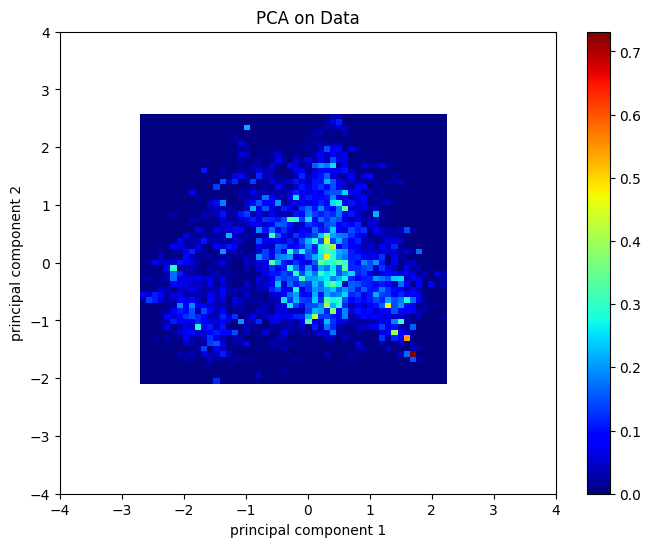

In [ ]:
alignment2d, _ = pca_from_onehot(alignment)

fig, ax = plt.subplots(figsize=(8,6))
h = ax.hist2d(
    alignment2d[:, 0],
    alignment2d[:, 1],
    bins=50,
    density=True,
    cmap='jet'
)

ax.set(
    title="PCA on Data",
    xlabel="principal component 1",
    ylabel="principal component 2",
)
ax.set_xticks(range(-4, 5))
ax.set_yticks(range(-4, 5))

plt.colorbar(h[3], ax=ax)
plt.show()

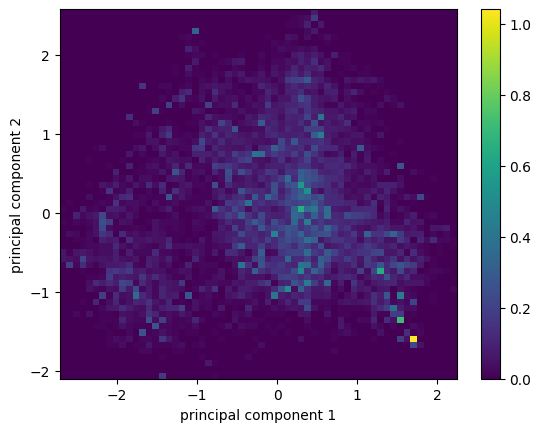

In [4]:
plt.hist2d(alignment2d[:,0], alignment2d[:,1], bins=60, density=True)
plt.xlabel("principal component 1"); plt.ylabel("principal component 2")
plt.colorbar(); plt.show()